In [72]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [52]:
covid = pd.read_csv("Data/Covid Data/Medical_Examiner_Case_Archive_-_COVID-19_Related_Deaths.csv")
covidCases = pd.read_csv('Data/Covid Data/COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code.csv')
caseCountByDate = covidCases
zip = pd.read_csv("Data/Zip_Codes.csv")
soc = pd.read_csv('Chicago Sociodemographics Zipcode.csv')

In [6]:
zipcodes = zip.ZIP.to_list()
zipcodes.remove(60666) #OHare Airport!!
covid = covid[covid['Residence Zip'].notna()]
sep = '-'
covid['Residence Zip'] = covid['Residence Zip'].apply(lambda x: x.split(sep, 1)[0])
covid['Residence Zip'] = covid['Residence Zip'].astype(str).astype(int)
covid = covid[covid['Residence Zip'].isin(zipcodes)]
covid['Date of Death'] = pd.to_datetime(covid['Date of Death'])
covid['Date of Death'] = covid['Date of Death'].dt.date
covid = covid[covid['Date of Death'] <= datetime.date(2022, 3, 5)]
covid = covid.sort_values(by=['Date of Death'])
covid = covid[(covid['Manner of Death']!='ACCIDENT') & (covid['Manner of Death']!='SUICIDE')]
covid = covid[covid['COVID Related'] == True]
covid = covid.rename(columns={"Residence Zip": "Zipcode"})

covid = covid.drop(['Case Number','Date of Incident','Manner of Death','Residence City', 'Primary Cause', 'Primary Cause Line A', 'Primary Cause Line B',
       'Primary Cause Line C', 'Secondary Cause', 'Gun Related', 'COVID Related', 'Opioid Related', 'Commissioner District',
       'Incident Address', 'Incident City', 'Incident Zip Code', 'longitude',
       'latitude', 'location', 'OBJECTID', 'Chicago Ward',
       'Chicago Community Area'],axis=1)

In [7]:
covidCases['Week Start'] = pd.to_datetime(covidCases['Week Start']).dt.date
covidCases['Week End'] = pd.to_datetime(covidCases['Week End']).dt.date
covidCases = covidCases[covidCases['Week End'] == datetime.date(2022, 3, 5)]
covidCases['Cases - Cumulative'] = covidCases['Cases - Cumulative'].apply(np.int64)
covidCases = covidCases[['ZIP Code', 'Cases - Cumulative']]
covidCases = covidCases[covidCases['ZIP Code'] != 'Unknown']
covidCases['ZIP Code'] = covidCases['ZIP Code'].astype(str).astype(int)
covidCases = covidCases[covidCases['ZIP Code'].isin(zipcodes)]
covidCases = covidCases.rename(columns={'ZIP Code': 'Zipcode'})
covidCases = covidCases.rename(columns={'Cases - Cumulative': 'Case Counts'})

In [8]:
deathCountByZip = covid.groupby('Zipcode').size().to_frame().reset_index().rename(columns={0: 'Death Counts'})

mergedSocCovid = pd.merge(soc, deathCountByZip, how='inner', on = 'Zipcode')
mergedSocCovid['Death Counts(Per 1000)'] = (mergedSocCovid['Death Counts'] / mergedSocCovid.Population) * 1000

mergedSocCovid = pd.merge(mergedSocCovid, covidCases, how='inner', on = 'Zipcode')
mergedSocCovid['Case Counts(Per 1000)'] = (mergedSocCovid['Case Counts'] / mergedSocCovid.Population) * 1000

mergedSocCovid = mergedSocCovid.round(2)

mergedSocCovid = mergedSocCovid.drop_duplicates()

In [9]:
mergedSocCovid.head()

,Zipcode,Population,Median age,Under 18(%),18 to 64(%),65 and over(%),Male(%),Female(%),White(%),Black(%),...,Europe(%),Asia(%),Africa(%),Oceania(%),Latin America(%),North America(%),Death Counts,Death Counts(Per 1000),Case Counts,Case Counts(Per 1000)
0,60647,85658,32.2,17.56,75.14,7.30,49.75,50.25,48.50,4.72,...,14.76,14.11,1.67,0.68,66.31,2.47,184,2.15,17196,200.75
1,60639,88515,34.6,26.29,62.24,11.47,49.90,50.10,8.07,13.24,...,4.69,2.99,0.61,0.00,91.67,0.03,278,3.14,24130,272.61
2,60707,42434,40.0,21.06,63.60,15.33,47.33,52.67,46.85,6.63,...,42.45,11.93,0.98,0.00,44.29,0.34,130,3.06,4235,99.80
4,60622,52957,32.2,13.41,79.84,6.75,50.64,49.36,64.44,5.35,...,38.17,19.04,1.60,0.50,38.03,2.65,89,1.68,11074,209.11
5,60651,63679,33.9,26.37,61.38,12.25,46.37,53.63,5.00,53.02,...,1.55,2.46,0.89,0.00,94.89,0.21,182,2.86,14030,220.32


In [23]:
mergedSocCovid.to_csv('Chicago-Covid-SocioDemographics-Cases-Deaths.csv', index=False)

In [10]:
deathCountByDate = covid.groupby('Date of Death').size().to_frame().reset_index().rename(columns={0: 'Death Counts'})

caseCountByDate = caseCountByDate.fillna(0)
caseCountByDate['Week Start'] = pd.to_datetime(caseCountByDate['Week Start']).dt.date
caseCountByDate['Week End'] = pd.to_datetime(caseCountByDate['Week End']).dt.date
caseCountByDate = caseCountByDate[caseCountByDate['ZIP Code'] != 'Unknown']
caseCountByDate['ZIP Code'] = caseCountByDate['ZIP Code'].astype(str).astype(int)
caseCountByDate = caseCountByDate[caseCountByDate['ZIP Code'].isin(zipcodes)]
caseCountByDate = caseCountByDate.rename(columns={'ZIP Code': 'Zipcode'})
caseCountByDate = caseCountByDate.sort_values(by='Week End')
caseCountByDate = caseCountByDate[['Week End','Cases - Weekly', 'Deaths - Weekly']]
caseCountByDate = caseCountByDate.rename(columns={'Week End': 'Date', 'Cases - Weekly': 'Cases'})
caseCountByDate = caseCountByDate.groupby('Date').sum().reset_index()

Text(0.5, 0, 'Date')

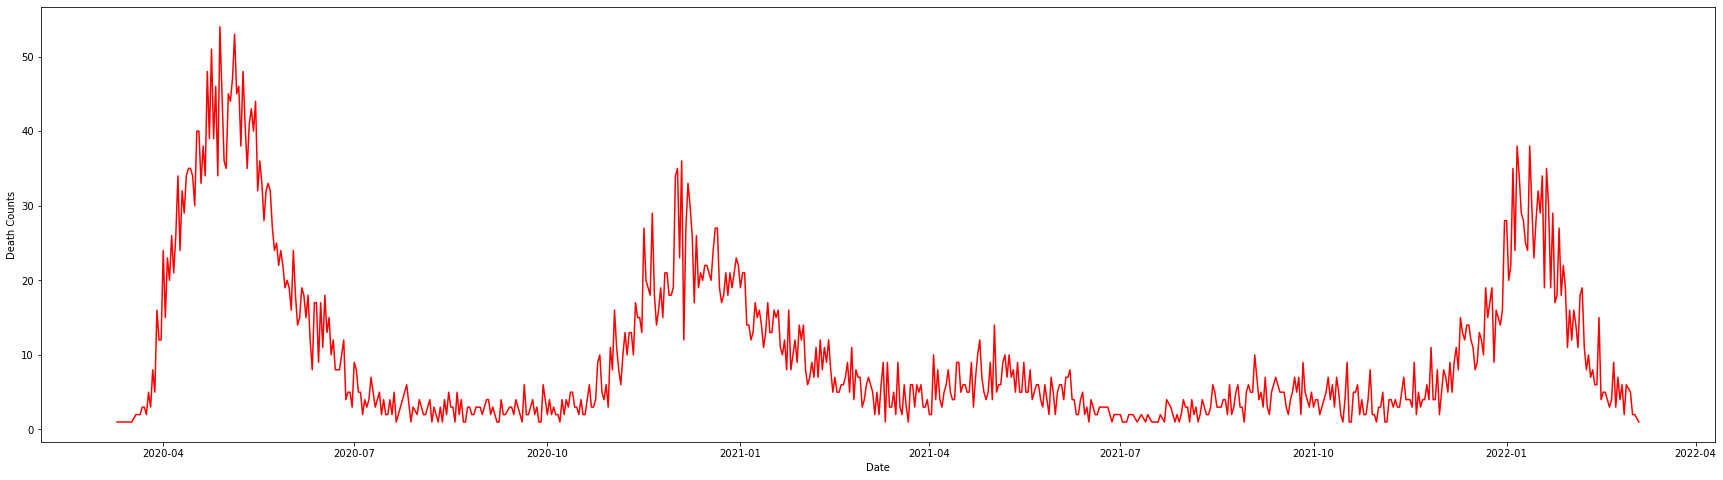

In [66]:
plt.figure(figsize=(30,8))
sns.lineplot(data=deathCountByDate, x="Date of Death", y="Death Counts", color='r')
plt.xlabel("Date")

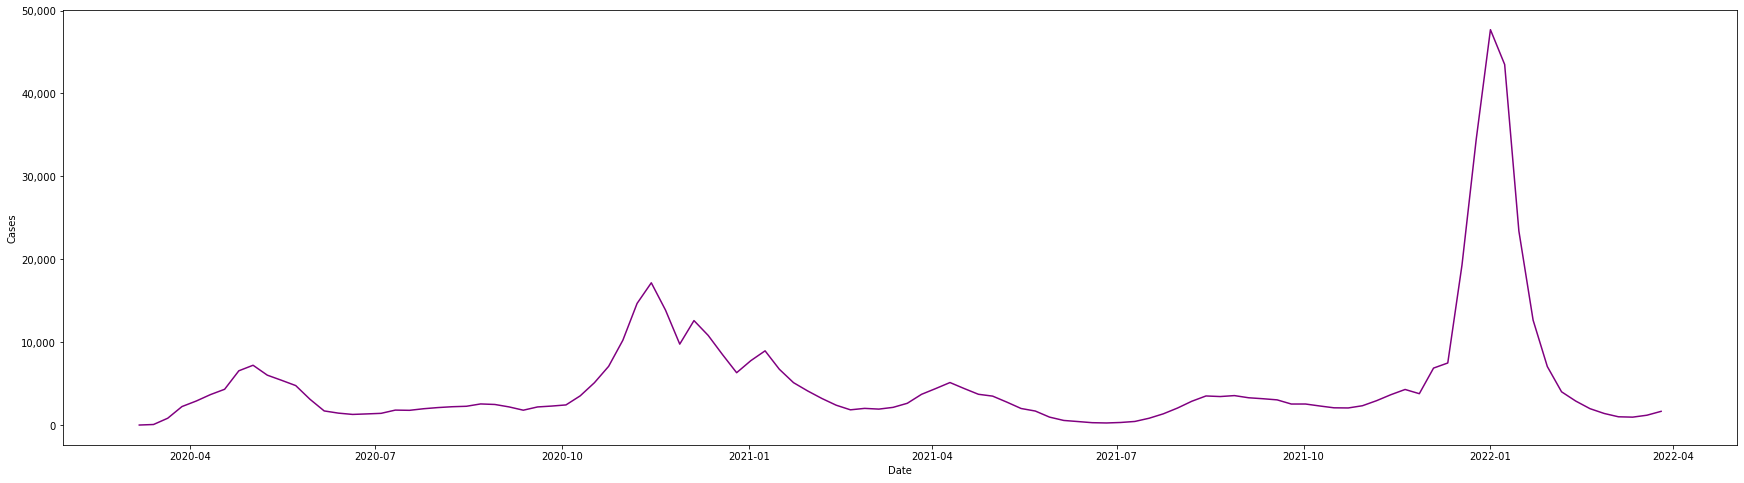

In [73]:
plt.figure(figsize=(30,8))
sns.lineplot(data=caseCountByDate, x="Date", y="Cases", color='Purple')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

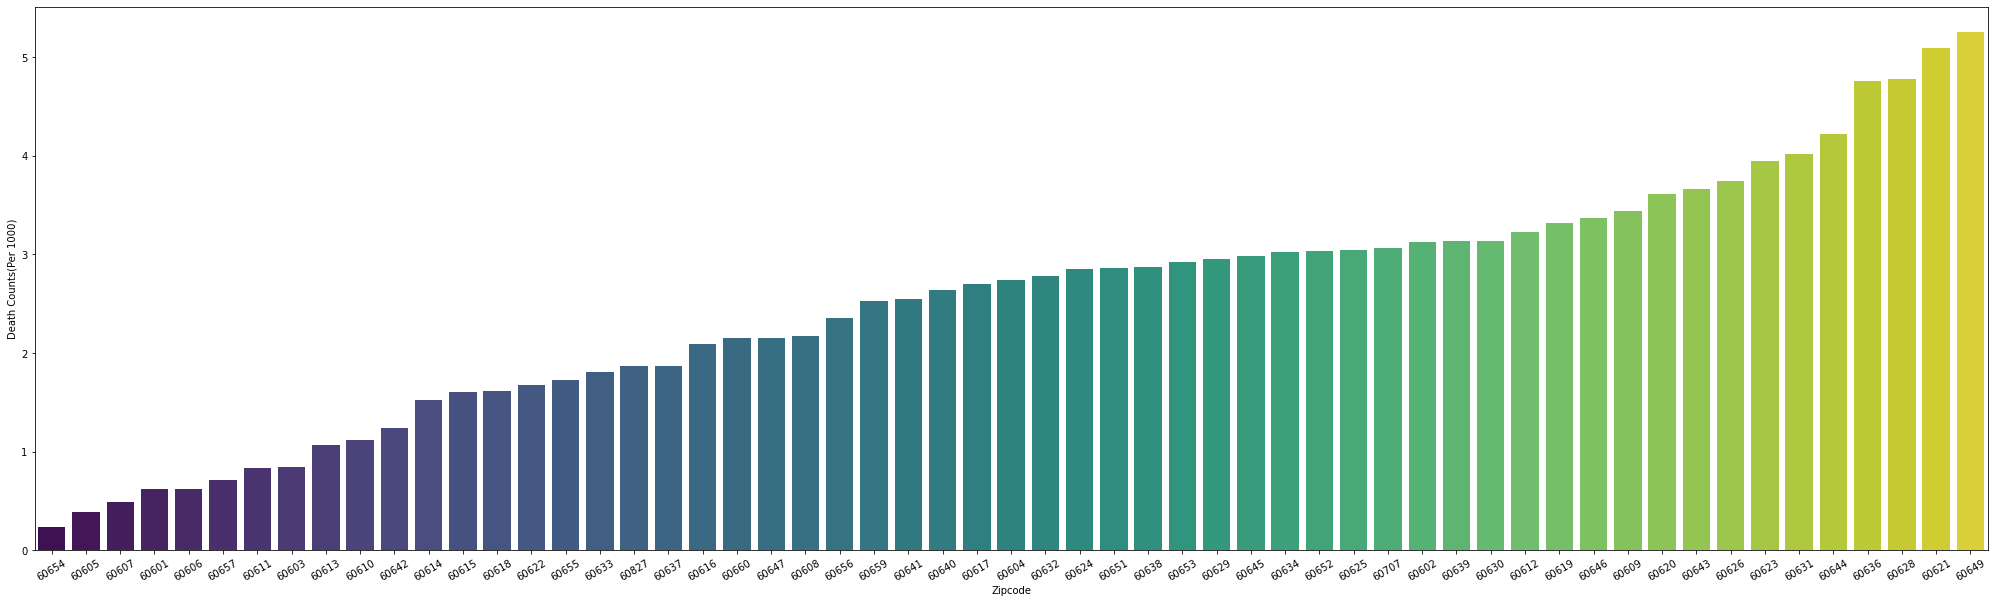

In [116]:
temp = mergedSocCovid.sort_values(by='Death Counts(Per 1000)')
plt.figure(figsize=(35,10))
ax = sns.barplot(data=temp, x=temp.Zipcode.apply(str), y='Death Counts(Per 1000)', palette='viridis');
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

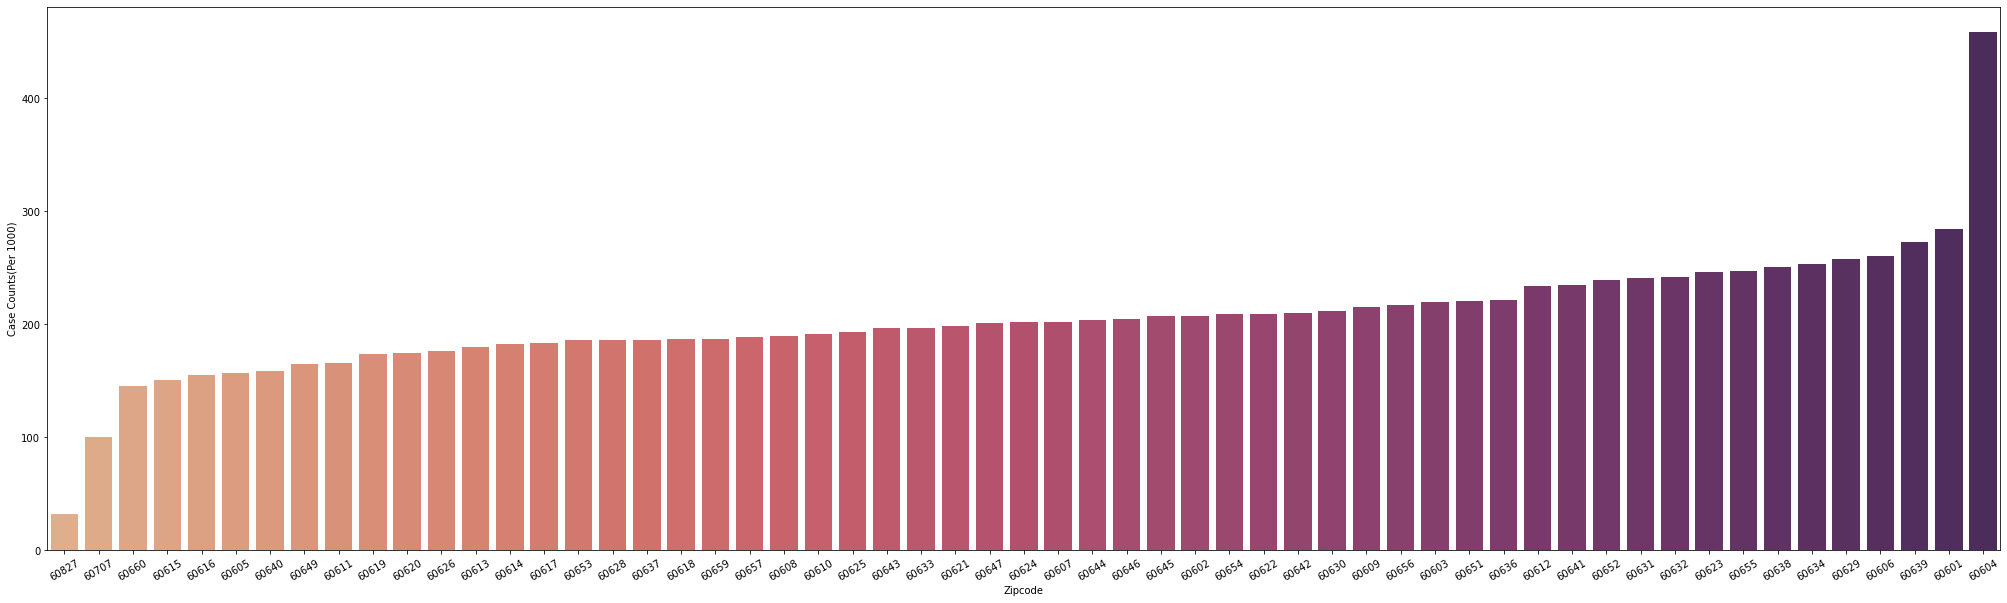

In [114]:
temp = mergedSocCovid.sort_values(by='Case Counts(Per 1000)')
plt.figure(figsize=(35,10))
ax = sns.barplot(data=temp, x=temp.Zipcode.apply(str), y='Case Counts(Per 1000)', palette='flare');
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

<AxesSubplot:xlabel='Median household income (USD)', ylabel='Death Counts(Per 1000)'>

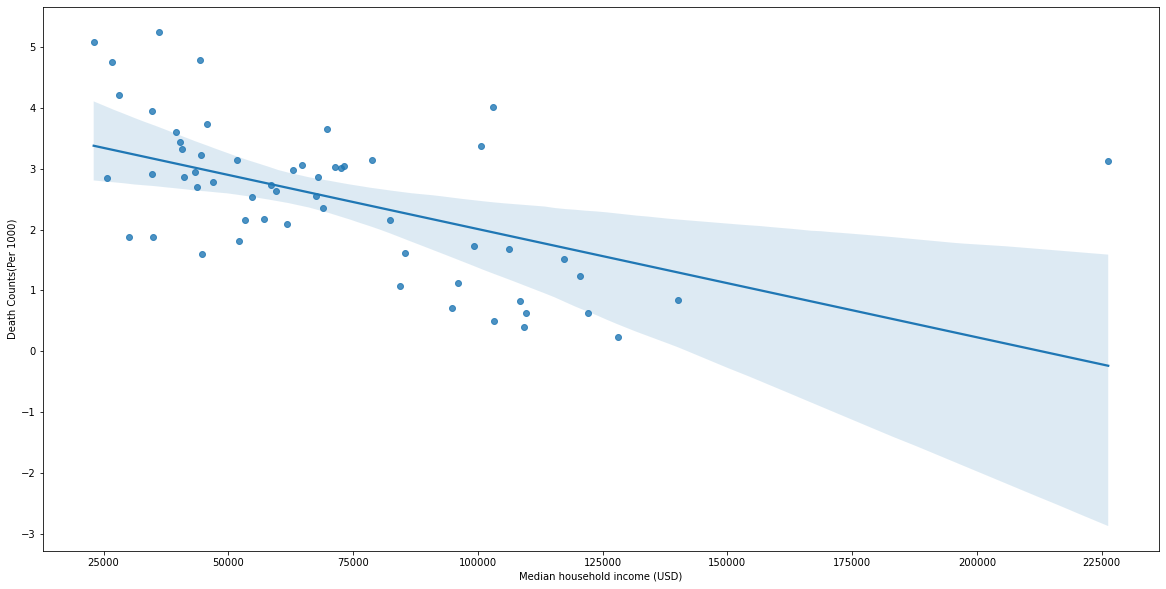

In [131]:
plt.figure(figsize=(20,10))
sns.regplot(data=mergedSocCovid, x="Median household income (USD)", y="Death Counts(Per 1000)")

In [119]:
mergedSocCovid.columns

Index(['Zipcode', 'Population', 'Median age', 'Under 18(%)', '18 to 64(%)',
       '65 and over(%)', 'Male(%)', 'Female(%)', 'White(%)', 'Black(%)',
       'Native(%)', 'Asian(%)', 'Islander(%)', 'Two plus(%)', 'Hispanic(%)',
       'Per capita income (USD)', 'Median household income (USD)',
       'Below poverty line(%)', 'Mean travel time to work (Minutes)',
       'Drove Alone (%)', 'Carpooled (%)', 'Public Transit (%)', 'Bicycle (%)',
       'Walked (%)', 'Other (%)', 'Worked at home (%)', 'Number of households',
       'Persons per household', 'Married (%)', 'Single (%)',
       'Number of housing units', 'Occupied housing (%)', 'Vacant housing (%)',
       'Owner Occupied (%)', 'Renter Occupied (%)', 'Median housing value',
       'Moved Since Prev Year(%)', 'Same House Prev Year(%)', 'No Degree(%)',
       'High School(%)', 'Some College(%)', 'Bachelor's(%)', 'Post-grad(%)',
       'Foriegn Born Population(%)', 'Europe(%)', 'Asia(%)', 'Africa(%)',
       'Oceania(%)', 'Latin Ame

<AxesSubplot:xlabel='Per capita income (USD)', ylabel='Death Counts(Per 1000)'>

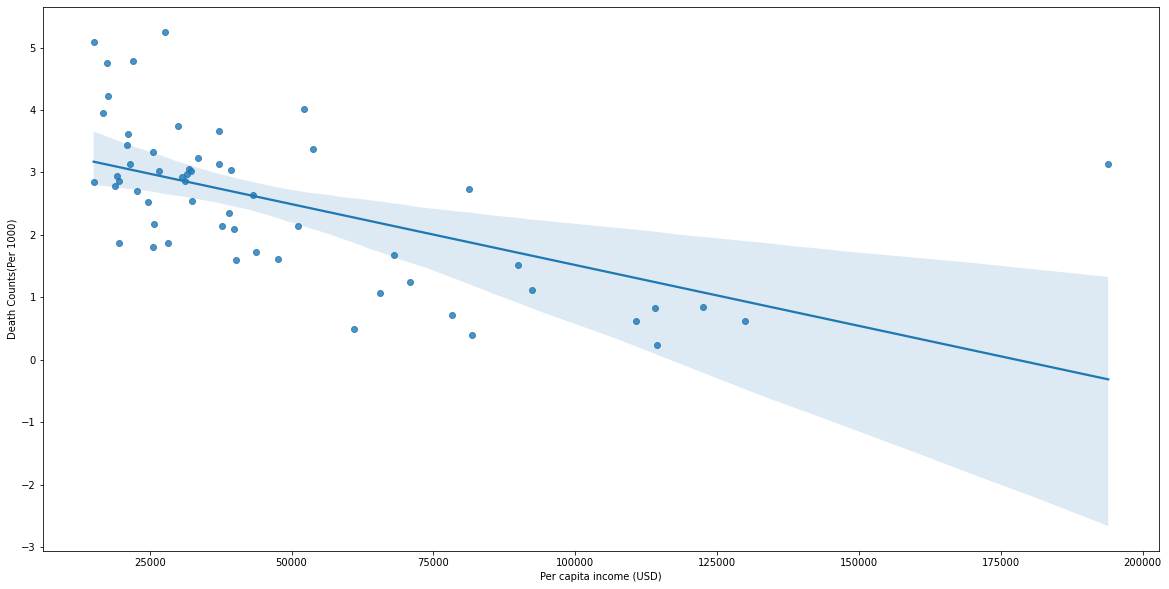

In [129]:
plt.figure(figsize=(20,10))
sns.regplot(data=mergedSocCovid, x="Per capita income (USD)", y="Death Counts(Per 1000)")

<AxesSubplot:xlabel='Below poverty line(%)', ylabel='Death Counts(Per 1000)'>

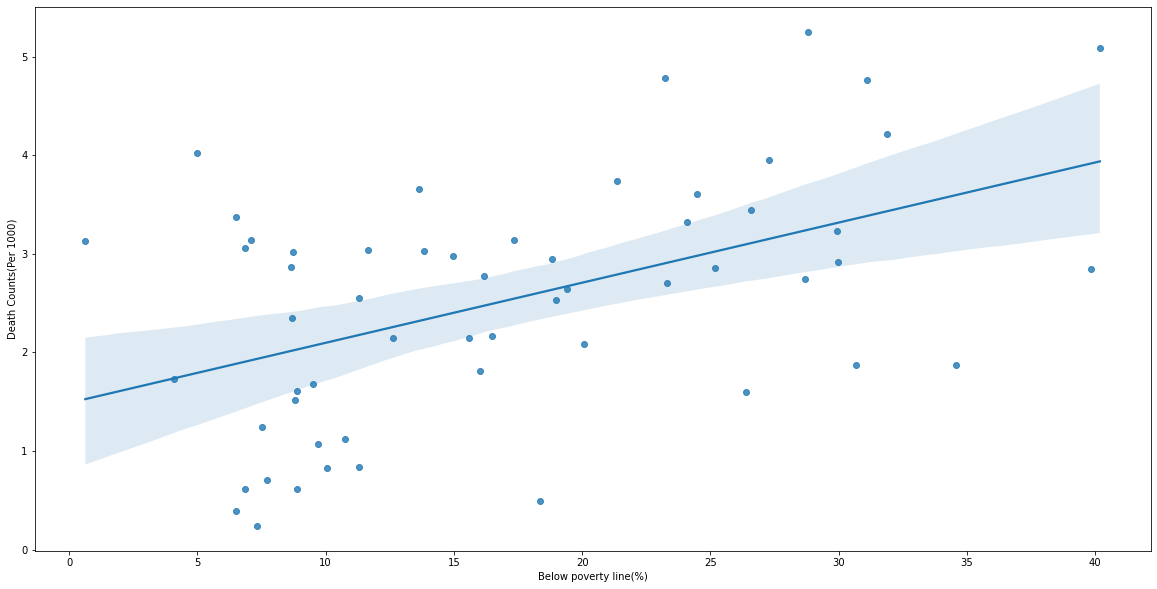

In [128]:
plt.figure(figsize=(20,10))
sns.regplot(data=mergedSocCovid, x="Below poverty line(%)", y="Death Counts(Per 1000)")

<AxesSubplot:xlabel='Median housing value', ylabel='Death Counts(Per 1000)'>

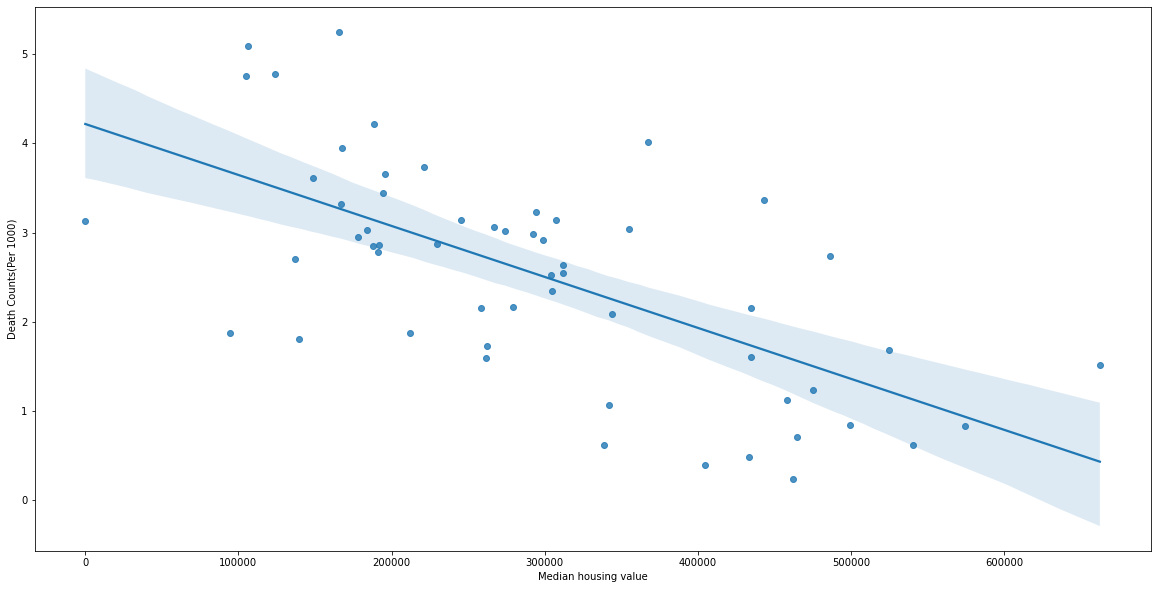

In [127]:
plt.figure(figsize=(20,10))
sns.regplot(data=mergedSocCovid, x="Median housing value", y="Death Counts(Per 1000)")

In [177]:
cormat = mergedSocCovid.corr().abs()
cormat = cormat[cormat>0.5]
feature_importance = round(cormat,2).dropna(subset=['Death Counts(Per 1000)'])['Death Counts(Per 1000)'].to_frame().reset_index()
feature_importance = feature_importance.sort_values(by='Death Counts(Per 1000)')[:-1]

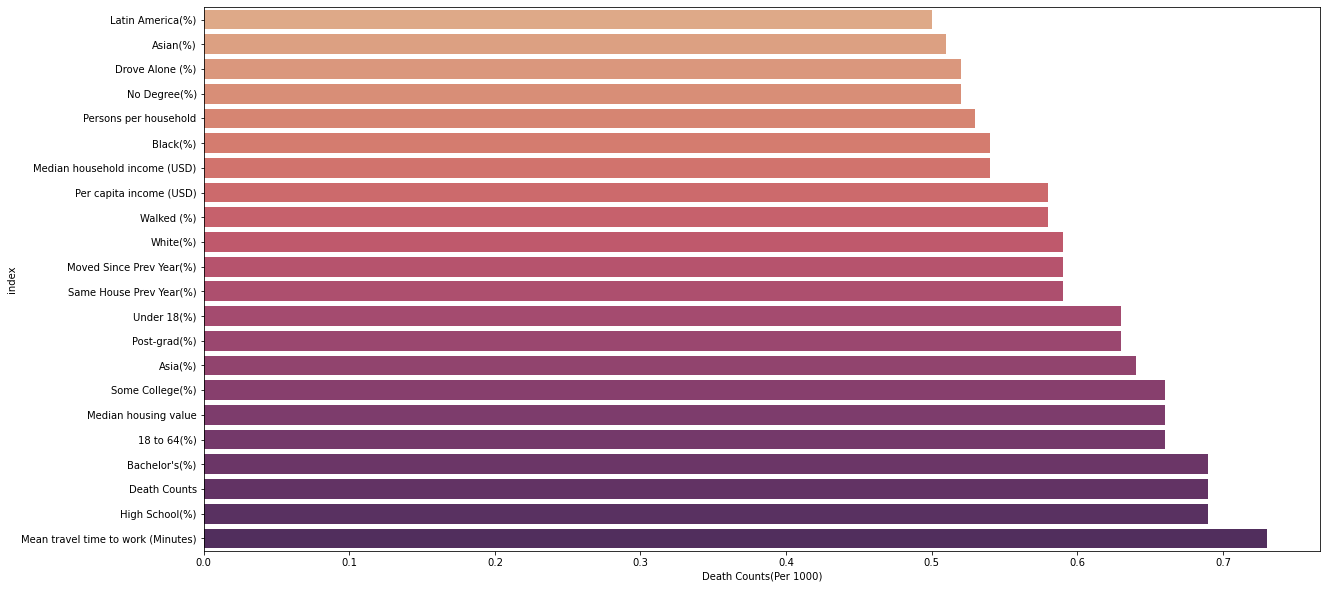

In [178]:
plt.figure(figsize=(20,10))
ax = sns.barplot(data=feature_importance, y='index', x='Death Counts(Per 1000)', palette='flare');